# Plotting Network Traffic Data With Matplotlib

Matplotlib is a powerful Python plotting library. With this library it is easy to produce;
- Scatter Plots
- Line Plots
- Bar Charts
- Pie Charts
- Waffle Charts
- Word Clouds
- Histograms
- Box Plots
- Heatmaps
- Subplots

In this study, we produce __Pie Chart__, __Histogram__ and __Line Chart__ plotting step by step. We prefer to use "network traffic data" for visualization, so we capture our computer's internet traffic data nearly 2 minute with <a href="https://www.wireshark.org/">WireShark</a> and export the as a .csv file. The data can be downloaded from <a href="https://github.com/msklc/Plotting-Network-Traffic-Data-With-Matplotlib/blob/master/network_traffic.csv">GitHub</a>.

## Preparing Data

First, we import the required libraries and load our network traffic data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv('network_traffic.csv')
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,12:50:38.589409,192.168.43.9,178.34.151.191,UDP,146,6881 > 9984 Len=104
1,2,12:50:39.555499,178.34.151.191,192.168.43.9,UDP,359,9984 > 6881 Len=317
2,3,12:50:43.069349,54.240.168.28,192.168.43.9,TLSv1.2,85,Encrypted Alert
3,4,12:50:43.069350,54.240.168.28,192.168.43.9,TCP,54,"443 > 50356 [FIN, ACK] Seq=32 Ack=1 Win=124 ..."
4,5,12:50:43.069350,54.240.168.61,192.168.43.9,TLSv1.2,100,Application Data


To see the total column and row numbers

In [3]:
df.shape

(15187, 7)

Than, get the summary information of data (row numbers, non-null values, data type of columns)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15187 entries, 0 to 15186
Data columns (total 7 columns):
No.            15187 non-null int64
Time           15187 non-null object
Source         15187 non-null object
Destination    15187 non-null object
Protocol       15187 non-null object
Length         15187 non-null int64
Info           15187 non-null object
dtypes: int64(2), object(5)
memory usage: 830.7+ KB


Convert the 'Time' column type as __datetime__ format

In [5]:
df['Time']= pd.to_datetime(df['Time']).astype('datetime64[s]') #convert column types as datetime

Create a new column as __Domain__ from the 'Info' column with the help of __regular expression__

Then filter the data with 'non-null Domain' information

In [6]:
df['Domain']=df['Info'].str.extract(r'((?:[a-z]*)(?:\.*)(?:[a-z]+)(?:\.)(?:[a-z]+))')
df[df['Domain'].notnull()].head()

,No.,Time,Source,Destination,Protocol,Length,Info,Domain
17,18,2019-11-25 12:50:48,192.168.43.9,192.168.43.1,DNS,70,Standard query 0xa530 A google.com,google.com
18,19,2019-11-25 12:50:48,192.168.43.1,192.168.43.9,DNS,86,Standard query response 0xa530 A google.com A ...,google.com
21,22,2019-11-25 12:50:48,192.168.43.9,192.168.43.1,DNS,87,Standard query 0x9f85 PTR 110.208.58.216.in-ad...,addr.arpa
22,23,2019-11-25 12:50:48,192.168.43.1,192.168.43.9,DNS,157,Standard query response 0x9f85 PTR 110.208.58....,addr.arpa
92,93,2019-11-25 12:51:00,192.168.43.9,192.168.43.1,DNS,76,Standard query 0xbe6f A web.whatsapp.com,web.whatsapp.com


Create a new column as __Host__ from the IP adress of 'Destination' column with the help of __socket library__

We use for loop to get the all the destination IP adresses

Also use try-except for bypass the errors

Then filter the data with 'non-Not Found' information

In [7]:
'''
import socket
ip_host={}
for ip_adress in list(df['Destination'].unique()):
    try:
        ip_host[ip_adress]=socket.gethostbyaddr(ip_adress)[0]
    except:
        ip_host[ip_adress]='Not Found'

df['Host']=df['Destination'].apply(lambda x: ip_host[x])
df[df['Host']!='Not Found'].head()
'''

"\nimport socket\nip_host={}\nfor ip_adress in list(df['Destination'].unique()):\n    try:\n        ip_host[ip_adress]=socket.gethostbyaddr(ip_adress)[0]\n    except:\n        ip_host[ip_adress]='Not Found'\n\ndf['Host']=df['Destination'].apply(lambda x: ip_host[x])\ndf[df['Host']!='Not Found'].head()\n"

Finally, we drop the unnecessary columns

In [8]:
df.drop(['No.','Info'], axis=1, inplace=True)
df.head() # Don't forget, some rows don't have a value in Domain column!!!

,Time,Source,Destination,Protocol,Length,Domain
0,2019-11-25 12:50:38,192.168.43.9,178.34.151.191,UDP,146,NaN
1,2019-11-25 12:50:39,178.34.151.191,192.168.43.9,UDP,359,NaN
2,2019-11-25 12:50:43,54.240.168.28,192.168.43.9,TLSv1.2,85,NaN
3,2019-11-25 12:50:43,54.240.168.28,192.168.43.9,TCP,54,NaN
4,2019-11-25 12:50:43,54.240.168.61,192.168.43.9,TLSv1.2,100,NaN


## Understanding Data

The network traffic data size is 1.92MB (in .csv file format). We can check the duration of traffic and the number of records by;

In [9]:
duration=df['Time'].max()-df['Time'].min()
total_record=df.shape[0]
print('The total records of {} seconds traffic data has {} rows'.format(duration,total_record))

The total records of 0 days 00:01:24 seconds traffic data has 15187 rows


As we know, _Source IP Address_ is the IP address of computer which is used by users. The _Destination IP Address_ is the IP address of server which the user want to reach. 

So, in network traffic data, it can be expected that _Source IP Address_ should be an unique value. But in real world, network traffic are two-way. So after a request made by users, the server send a reply. So, the _Source IP Address_ of a network traffic data include both the IP addresses of computer and server.

We can find the real _Source IP Address_ from the 'Info' column which don't have a domain adress. We already capture the domain adresses from 'Info' column with regular expression and save them as a new column 'Domain'.

We can get real _Source IP Address_ with the help of 'Domain' info as; 

In [10]:
df[df['Domain'].notnull()]['Source'].value_counts()

192.168.43.9              359
192.168.43.1              194
fe80::c:5938:664a:f8af      6
Name: Source, dtype: int64

__As a Result:__

- The data has 15187 rows (records) in 84 seconds!
- The data has 2 Source IP Address, what it mean is; it was used neither a virtual machine or the internet connection was corrupted and reconnected again
- The adress of __fe80::c:5938:664a:f8af__ is a IPv6 gateway IP address. So, it is understood that the user configured the IP v6.

## Visualization

Now, we visualize the data with __matplotlib__ library

### Pie Chart

Firstly, visualize the 'Protocol' column with __matplotlib pie chart__

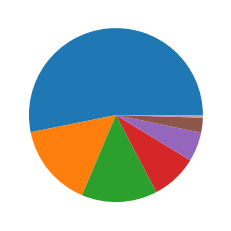

In [11]:
plt.figure()
x=df['Protocol'].value_counts()
plt.pie(x)
plt.show()

Add labels to the chart with __label__ parameter

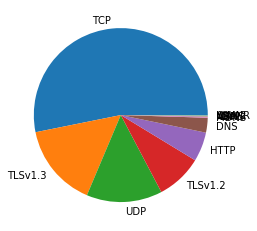

In [12]:
plt.figure()
x=df['Protocol'].value_counts()
labels=x.index
plt.pie(x,labels=labels)
plt.show()

It is seen easily that, apart from the first 6 labels (TCP, TLSv1.3, UDP, TLSv1.2, HTTP, DNS), other labels have a small count of value. So, we can limit the data with the first 6 label and grouped the rest with __Other__ label.

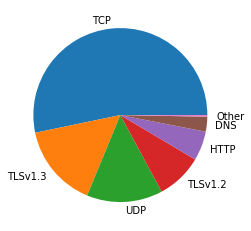

In [13]:
plt.figure()
x=df['Protocol'].value_counts()[0:6] # limiting first 6 value
other_sum=sum(df['Protocol'].value_counts()[7:]) # summing the other values
x.at['Other']=other_sum #adding a new key-value pair to our list
labels=x.index
plt.pie(x,labels=labels)
plt.show()

Explode/expand the first pie slice with __explode__ parameter.

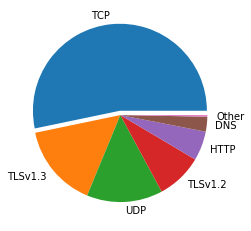

In [14]:
plt.figure()
x=df['Protocol'].value_counts()[0:6] # limiting first 6 value
other_sum=sum(df['Protocol'].value_counts()[7:]) # summing the other values
x.at['Other']=other_sum #adding a new key-value pair to our list
labels=x.index
explode = np.append([0.05],np.zeros(len(x)-1)) # explode 1st slice
plt.pie(x,labels=labels,explode=explode)
plt.show()

Add the percentage values of data with the __autopct__ parameter.

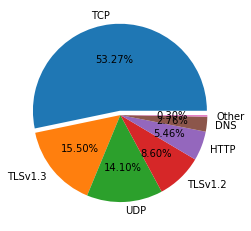

In [15]:
plt.figure()
x=df['Protocol'].value_counts()[0:6] # limiting first 6 value
other_sum=sum(df['Protocol'].value_counts()[7:]) # summing the other values
x.at['Other']=other_sum #adding a new key-value pair to our list
labels=x.index
explode = np.append([0.05],np.zeros(len(x)-1)) # explode 1st slice
plt.pie(x,labels=labels,explode=explode,autopct='%.02f%%')
plt.show()

Add title with fonsize of 20 with __plt.title__ function

Arrange the plot size with __figsize__ parameter

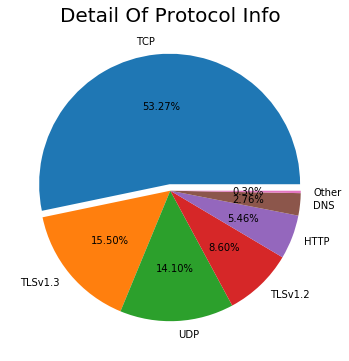

In [16]:
plt.figure(figsize=(10,6)) #Arrange the figure size
x=df['Protocol'].value_counts()[0:6] # limiting first 6 value
other_sum=sum(df['Protocol'].value_counts()[7:]) # summing the other values
x.at['Other']=other_sum #adding a new key-value pair to our list
labels=x.index
explode = np.append([0.05],np.zeros(len(x)-1)) # explode 1st slice
plt.pie(x,labels=labels,explode=explode,autopct='%.02f%%')
plt.title('Detail Of Protocol Info', fontsize=20) # Title of chart
plt.show()

### Histogram

Secondly, visualize the 'Protocol' column with __matplotlib histogram__

Histogram is a kind of bar chart, that shows the frequency of a data

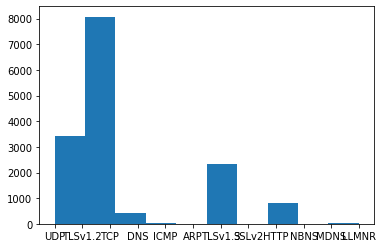

In [17]:
plt.figure()
plt.hist(df['Protocol'])
plt.show()

Arrange the bar chart and xticks values with __bins__ parameter

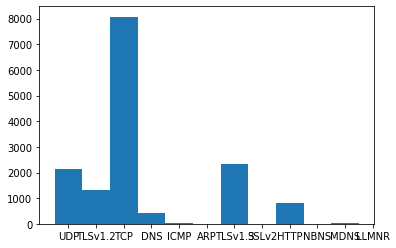

In [18]:
plt.figure()
plt.hist(df['Protocol'],
        bins = np.arange(len(df['Protocol'].value_counts())) - 0.5)
plt.show()

Arrange the _width_ for bar chart with __rwidth__ parameter.

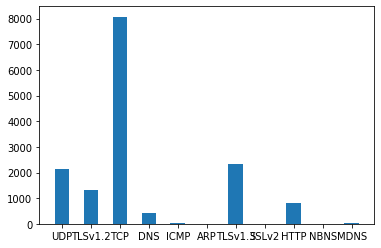

In [19]:
plt.figure()
plt.hist(df['Protocol'],
        bins = np.arange(len(df['Protocol'].value_counts())) - 0.5,
        rwidth=0.5)
plt.show()

Rotate the xticks values with __plt.xticks__ function.

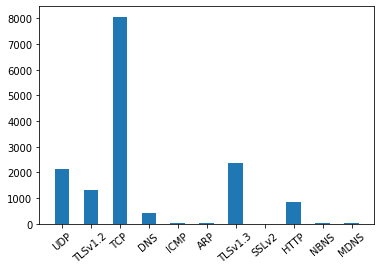

In [20]:
plt.figure()
plt.hist(df['Protocol'],
        bins = np.arange(len(df['Protocol'].value_counts())) - 0.5,
        rwidth=0.5)
plt.xticks(rotation=40)

plt.show()

Add the values of data with the __plt.text__ function.

For get the x,y location of every char plot; we use the return values of plt.hist

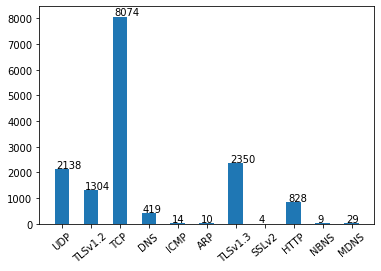

In [21]:
plt.figure()
counts, _, patches=plt.hist(df['Protocol'],
        bins = np.arange(len(df['Protocol'].value_counts())) - 0.5,
        rwidth=0.5)

for count, patch in zip(counts,patches):
    plt.text(x=patch.get_x()+0.05, y=patch.get_height()+50,s=str(int(count))) #x-location, y=location, value

plt.xticks(rotation=40)

plt.show()

Remove the top, left and right frames with __set.visible__ parameter

Also remove the yticks with null values

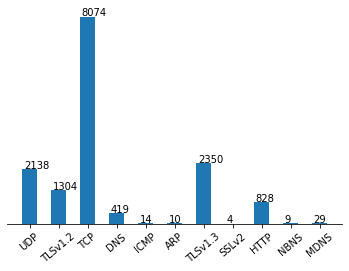

In [22]:
plt.figure()
counts, _, patches=plt.hist(df['Protocol'],
        bins = np.arange(len(df['Protocol'].value_counts())) - 0.5,
        rwidth=0.5)

xvals = patch.get_x() # x-location
yvals = patch.get_height() # y-location
for count, patch in zip(counts,patches):
    plt.text(x=patch.get_x()+0.05, y=patch.get_height()+50,s=str(int(count)))

[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'left','right']] #Remove top, left and right frame
plt.yticks([]) #disable ythicks
plt.xticks(rotation=40)


plt.show()

Add title with fonsize of 20 with __plt.title__ function

Arrange the plot size with __figsize__ parameter

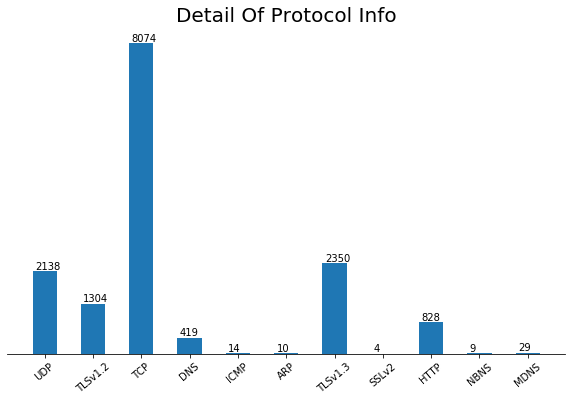

In [23]:
plt.figure(figsize=(10, 6))
counts, _, patches=plt.hist(df['Protocol'],
        bins = np.arange(len(df['Protocol'].value_counts())) - 0.5,
        rwidth=0.5)

xvals = patch.get_x() # x-location
yvals = patch.get_height() # y-location
for count, patch in zip(counts,patches):
    plt.text(x=patch.get_x()+0.05, y=patch.get_height()+50,s=str(int(count)))

[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'left','right']] #Remove top, left and right frame
plt.yticks([]) #disable ythicks
plt.xticks(rotation=40)

plt.title('Detail Of Protocol Info', fontsize=20) # Title of chart

plt.show()

### Line Chart

Thirdly, visualize the 'Length' (packet size)/'Time' column with __matplotlib line plot__

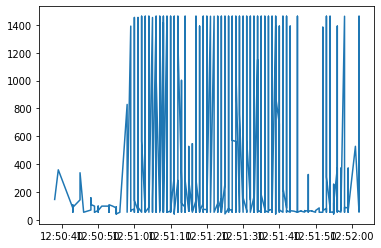

In [24]:
plt.figure()
plt.plot(df['Time'],df['Length'])
plt.show()

As we mentioned before, the total row number is 15187! in 84 seconds. So it is not easy to show the size of packets clearly in every microseconds. So, we can prefer to visialize the time info in second level. It means, we need to sum up the total size packet for every second and grouping them. We can use __groupby__ function.

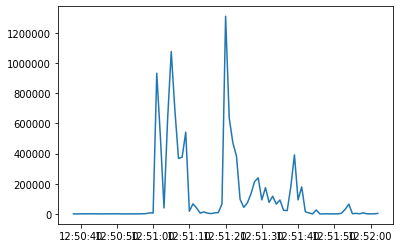

In [25]:
plt.figure()
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum())
plt.show()

Rotate the xticks values with __plt.xticks__ function.

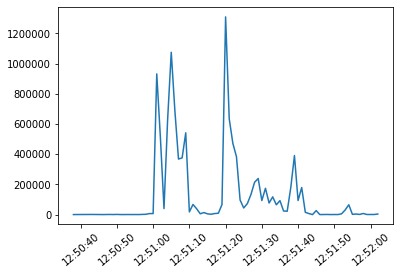

In [26]:
plt.figure()
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum())

plt.xticks(rotation=40)

plt.show()

Arrange the color of line with __color__ parameter and the style of line with __linestyle__ or __ls__ parameter.

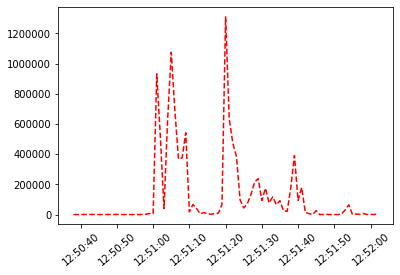

In [27]:
plt.figure()
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum(),
        color='red',
        linestyle='--')

plt.xticks(rotation=40)

plt.show()

Add marker and arrange the marker style,color and size with __marker__,__markeredgecolor__ (or __mec__),__markerfacecolor__ (or __mfc__) and __markersize__ (or __ms__) parameters.

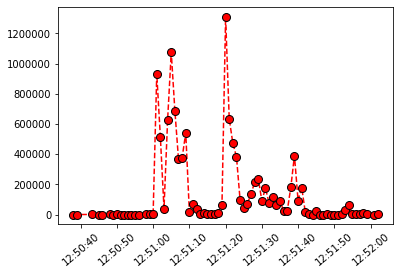

In [28]:
plt.figure()
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum(),
        color='red',
        linestyle='--',
        marker='o',
        markeredgecolor='black',
        markerfacecolor='red',
        markersize=8)

plt.xticks(rotation=40)

plt.show()

Remove the top, left and right frames with __set.visible__ parameter

Also remove the yticks with null values

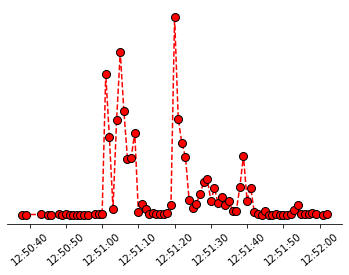

In [29]:
plt.figure()
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum(),
        color='red',
        linestyle='--',
        marker='o',
        markeredgecolor='black',
        markerfacecolor='red',
        markersize=8)

[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'left','right']] #Remove top, left and right frame
plt.yticks([]) #disable ythicks
plt.xticks(rotation=40)

plt.show()

Fill the area under the line with __fill_between__ function and arrange the color and transparancy of the filling with __facecolor__ and __alpha__ parameters.

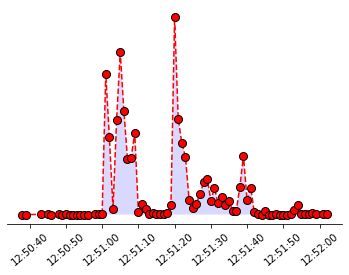

In [30]:
plt.figure()
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum(),
        color='red',
        linestyle='--',
        marker='o',
        markeredgecolor='black',
        markerfacecolor='red',
        markersize=8)

##Fill the area under the line
plt.gca().fill_between(df.groupby(by='Time')['Length'].sum().index, # x-location
                       df.groupby(by='Time')['Length'].sum(), 0,  #y-up location and y-down location
                       facecolor='blue', alpha=0.15) #parameter of color and transparency

[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'left','right']] #Remove top, left and right frame
plt.yticks([]) #disable ythicks
plt.xticks(rotation=40)
  
plt.show()

Add title with fonsize of 20 with __plt.title__ function

Arrange the plot size with __figsize__ parameter

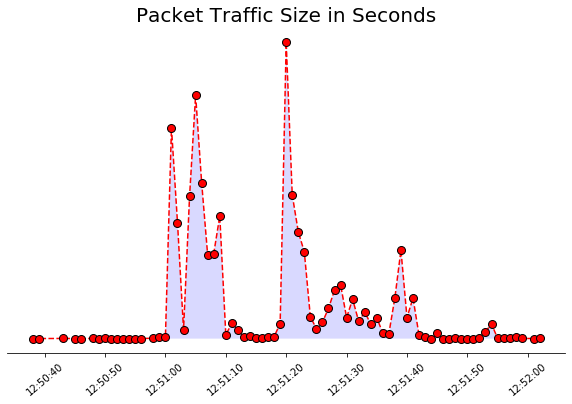

In [31]:
plt.figure(figsize=(10,6))
plt.plot(df.groupby(by='Time')['Length'].sum().index,df.groupby(by='Time')['Length'].sum(),
        color='red',
        linestyle='--',
        marker='o',
        markeredgecolor='black',
        markerfacecolor='red',
        markersize=8)

##Fill the area under the line
plt.gca().fill_between(df.groupby(by='Time')['Length'].sum().index, # x-location
                       df.groupby(by='Time')['Length'].sum(), 0,  #y-up location and y-down location
                       facecolor='blue', alpha=0.15) #parameter of color and transparency

[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'left','right']] #Remove top, left and right frame
plt.yticks([]) #disable ythicks
plt.xticks(rotation=40)
plt.title('Packet Traffic Size in Seconds', fontsize=20) # Title of chart
  
plt.show()

__Don't forget!__

This study is only prepared for a small demostration of the power of python matplotlib library. For detail information please visit <a href="https://matplotlib.org/">Matplotlib Web Site</a>
